# Import necessary Python libraries

In [2]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 2.9 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib
import xgboost as xgb
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

# Data Import


In [5]:
A = np.load('/data/penalty_matrix.npy')

train = pd.read_csv('/data/CSV_train.csv', sep=';')

test = pd.read_csv('/data/CSV_test.csv', sep=';')

In [6]:
train.sample(10)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
358807,25/5-4,2410.864305,470379.37500,6608141.5,-2385.303711,ROGALAND GP.,Vaale Fm.,13.426253,NaN,1.289138,...,NaN,NaN,1.176252,0.130643,NaN,NaN,NaN,-999.900024,65000,1.0
211830,25/11-15,1651.151700,470523.37500,6560848.5,-1627.499878,HORDALAND GP.,Grid Fm.,9.268112,0.464316,0.580647,...,20.407717,NaN,NaN,-0.092030,0.135404,NaN,NaN,NaN,65000,1.0
354236,25/5-4,1716.072305,470379.62500,6608159.5,-1690.781006,HORDALAND GP.,Grid Fm.,13.923372,NaN,0.874792,...,NaN,NaN,1.673372,0.051722,NaN,NaN,NaN,-999.900024,65000,1.0
693541,31/6-8,1944.668434,537151.93750,6713675.0,-1919.587524,VIKING GP.,Krossfjord Fm.,8.287967,NaN,0.460192,...,NaN,NaN,NaN,-0.008555,NaN,NaN,NaN,NaN,30000,1.0
417603,25/8-5 S,2498.686400,464012.00000,6590896.0,-2346.968262,ROGALAND GP.,Lista Fm.,8.287407,1.180006,1.178047,...,11.956285,NaN,-0.212593,0.041013,1.222229,NaN,NaN,1.190629,65000,1.0
928576,34/8-1,1557.049023,469662.28125,6803718.5,-1534.008667,HORDALAND GP.,Utsira Fm.,18.078920,NaN,0.791581,...,NaN,NaN,NaN,0.050785,NaN,NaN,NaN,NaN,65000,1.0
505156,30/3-3,2168.398000,497350.65625,6737318.0,-2146.292480,ROGALAND GP.,Lista Fm.,13.396962,1.329799,0.883460,...,NaN,NaN,NaN,0.010822,NaN,NaN,NaN,1.332075,65000,1.0
777593,34/10-21,2915.698403,454130.25000,6777267.5,-2886.239014,CROMER KNOLL GP.,Aasgard Fm.,14.980711,1.490289,3.185820,...,NaN,NaN,NaN,0.037902,NaN,NaN,NaN,1.354996,65030,2.0
193234,17/11-1,392.113016,520153.18750,6452287.5,-365.113007,NORDLAND GP.,NaN,20.650301,NaN,1.096277,...,368.656738,NaN,NaN,NaN,1.090420,NaN,NaN,NaN,65000,1.0
1015251,35/11-12,3189.298000,520571.12500,6777330.0,-3164.814941,VIKING GP.,Heather Fm.,8.953847,NaN,7.334038,...,6.628118,142.588196,NaN,0.020000,NaN,NaN,NaN,NaN,65000,1.0


# Exploratory Data Analysis & Visualization

## EDA

Let us look at the number of wells for training and testing in the dataset.

In [7]:
Alldata=pd.concat([train, test], axis=0).reset_index().rename(columns={'index': 'idx'})
Alldata.loc[train.index, 'Dataset'] = 'Train'
Alldata.loc[train.index.max()+1:, 'Dataset'] = 'Test'

In [8]:
train_wells = Alldata['WELL'][Alldata.Dataset=='Train'].unique()
print('No of train wells: %s' % len(train_wells))

No of train wells: 98


In [9]:
test_wells = Alldata['WELL'][Alldata.Dataset=='Test'].unique()
print('No of test wells: %s' % len(test_wells))

No of test wells: 10


We will create a dictionary of the lithology names with respect to their unique number key present in the dataset.

In [10]:
lithology_keys = {} # initialize dictionary
litho=['Sandstone', 'Shale', 'SandyShale', 'Limestone', 'Chalk', 'Dolomite',
       'Marl', 'Anhydrite', 'Halite', 'Coal', 'Basement', 'Tuff']
col = np.sort(Alldata['FORCE_2020_LITHOFACIES_LITHOLOGY'][Alldata.Dataset=='Train'].unique())
for index, name in enumerate(col):
    lithology_keys[name] = litho[index]
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}
lithology_keys

{30000: 'Sandstone',
 65030: 'Sandstone/Shale',
 65000: 'Shale',
 80000: 'Marl',
 74000: 'Dolomite',
 70000: 'Limestone',
 70032: 'Chalk',
 88000: 'Halite',
 86000: 'Anhydrite',
 99000: 'Tuff',
 90000: 'Coal',
 93000: 'Basement'}

Let us look at the count of different facies labels. 

/tmp/ipykernel_112349/3664829130.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=45)


Text(0, 0.5, 'Lithology presence (\\%)')

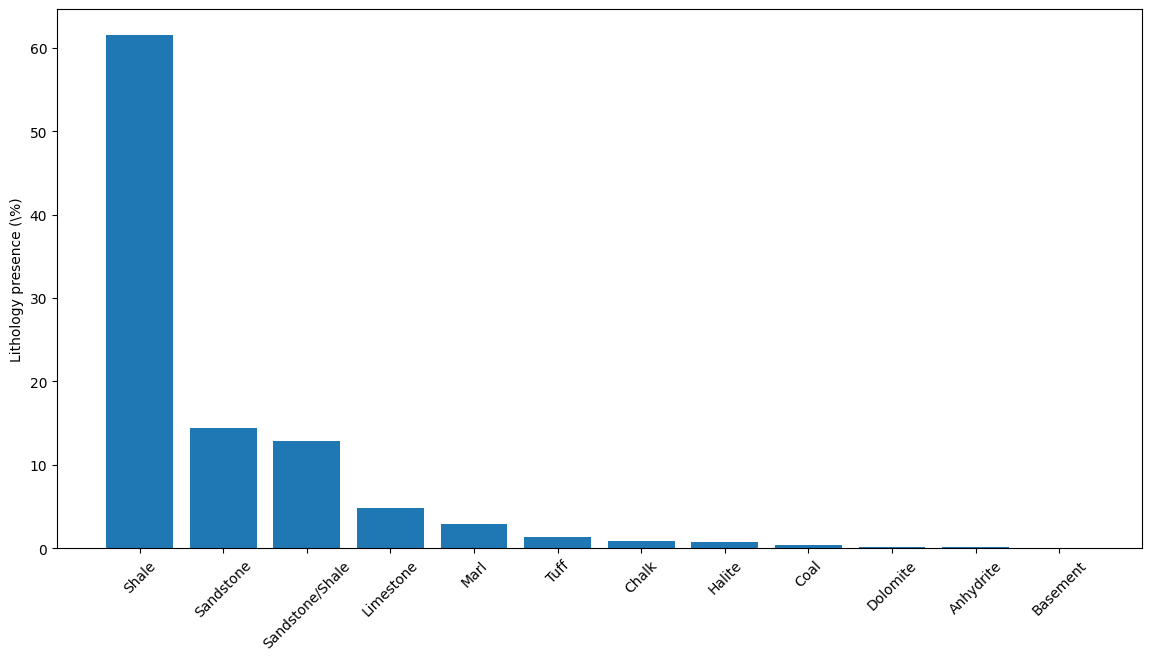

In [12]:
counts = train['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()
names = []
percentage = []
N = train['FORCE_2020_LITHOFACIES_LITHOLOGY'].shape[0]
for item in counts.items():
    names.append(lithology_keys[item[0]])
    percentage.append(float(item[1])/N*100)
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(len(names)), height=percentage)
ax.set_xticklabels(names, rotation=45)
ax.set_xticks(np.arange(len(names)))
ax.set_ylabel('Lithology presence (\%)')

Create a list of feature names to be used for training the ML model. 

In [13]:
feature_names = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'GR', 'RSHA', 'RMED', 'RDEP', 'RHOB',
                 'NPHI', 'PEF', 'DTC', 'DTS', 'SP', 'ROP', 'BS']

Create a dictionary of unique colours for each facies label, for visualization purposes.

In [14]:
facies_names = lithology_keys.values()
facies_colors = ['darkorange', '#228B22', 'grey', 'cyan', 'gold', 'lightseagreen',
                 'lawngreen', 'lightblue', 'tan', '#FF4500', '#000000', 'magenta']
#
#facies_color_map is a dictionary that maps facies labels to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_names):
    facies_color_map[label] = facies_colors[ind]

We will create a new dictionary of sequential facies numbering with respect to the unique lithology numbers in the dataset.  

In [15]:
Y = Alldata['FORCE_2020_LITHOFACIES_LITHOLOGY']
lithology_numbers = {} # initialize dictionary
lithology_numbers = {30000: 0,
                     65030: 1,
                     65000: 2,
                     80000: 3,
                     74000: 4,
                     70000: 5,
                     70032: 6,
                     88000: 7,
                     86000: 8,
                     99000: 9,
                     90000: 10,
                     93000: 11}
display(lithology_keys)
Y = Y.map(lithology_numbers)
Y.unique()

{30000: 'Sandstone',
 65030: 'Sandstone/Shale',
 65000: 'Shale',
 80000: 'Marl',
 74000: 'Dolomite',
 70000: 'Limestone',
 70032: 'Chalk',
 88000: 'Halite',
 86000: 'Anhydrite',
 99000: 'Tuff',
 90000: 'Coal',
 93000: 'Basement'}

array([ 2.,  0.,  1.,  5.,  9.,  3.,  8.,  4.,  6., 10.,  7., 11., nan])

Store well labels and depths for training data

In [16]:
well = Alldata['WELL']
dataset = Alldata[['idx', 'Dataset']]
depth = Alldata['DEPTH_MD']
Strat = Alldata['GROUP']
Formation = Alldata['FORMATION']

In [17]:
X_all = Alldata.drop(columns=['WELL', 'FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE',
                              'idx', 'Dataset'])
X=X_all[feature_names]

Y=Y.reindex(X.index)
Strat=Strat.reindex(X.index)
Formation=Formation.reindex(X.index)

In [18]:
#Zero imputer
X_imp=X.fillna(0)
X_imp.describe()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,GR,RSHA,RMED,RDEP,RHOB,NPHI,PEF,DTC,DTS,SP,ROP,BS
count,1.307297e+06,1.307297e+06,1.307297e+06,1.307297e+06,1.307297e+06,1.307297e+06,1.307297e+06,1.307297e+06,1.307297e+06,1.307297e+06,1.307297e+06,1.307297e+06,1.307297e+06,1.307297e+06,1.307297e+06,1.307297e+06,1.307297e+06
mean,2.217261e+03,4.797504e+05,6.628721e+06,-2.147925e+03,1.218500e+01,7.031829e+01,5.253029e+00,4.717007e+00,9.865322e+00,1.977126e+00,2.193081e-01,3.777892e+00,1.058195e+02,3.346444e+01,4.190659e+01,5.760407e+01,6.792050e+00
std,1.006788e+03,5.609554e+04,6.194671e+05,9.864015e+02,4.945737e+00,3.396652e+01,7.016473e+01,5.146719e+01,1.076017e+02,8.198512e-01,1.880176e-01,8.926784e+00,3.968701e+01,8.010788e+01,6.806375e+01,9.871182e+02,6.350431e+00
min,1.360860e+02,0.000000e+00,0.000000e+00,-5.395563e+03,0.000000e+00,1.092843e-01,0.000000e+00,-8.418695e-03,0.000000e+00,0.000000e+00,-3.582247e-02,0.000000e+00,0.000000e+00,0.000000e+00,-9.990000e+02,-1.179770e-01,0.000000e+00
25%,1.443348e+03,4.544695e+05,6.590892e+06,-2.843063e+03,8.868817e+00,4.722087e+01,0.000000e+00,8.766262e-01,8.968398e-01,2.005296e+00,0.000000e+00,0.000000e+00,8.405653e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.113328e+03,4.767682e+05,6.737676e+06,-2.068498e+03,1.242531e+01,6.731985e+01,3.901408e-01,1.426823e+00,1.450366e+00,2.249889e+00,2.383749e-01,3.058908e+00,1.049414e+02,0.000000e+00,3.690100e+01,0.000000e+00,8.500000e+00
75%,2.907089e+03,5.183656e+05,6.784906e+06,-1.399016e+03,1.545700e+01,8.853503e+01,1.435587e+00,2.628997e+00,2.569593e+00,2.469035e+00,3.649973e-01,4.728402e+00,1.389161e+02,0.000000e+00,6.724650e+01,1.608300e+01,1.225000e+01
max,5.436632e+03,5.726328e+05,6.856661e+06,0.000000e+00,2.827900e+01,1.076964e+03,2.193905e+03,1.988616e+03,1.999887e+03,3.457820e+00,9.995703e-01,3.831300e+02,3.204789e+02,6.765781e+02,5.265473e+02,4.701512e+04,2.600000e+01


## Log plot

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
def make_facies_log_plot(logs, curves, well_name, facies_colors):

    #make sure logs are sorted by depth
    cmap_facies = colors.ListedColormap(facies_colors, 'indexed')

    colours=['k','b','r','g','m','c','lime','gold','sienna']

    ztop=logs.Depth.min(); zbot=logs.Depth.max()

    cluster=np.repeat(logs['litho_real'].values.reshape(-1, 1),50,axis=1)

    num_curves = len(curves)
    f, ax = plt.subplots(nrows=1, ncols=num_curves+1, figsize=(num_curves*2, 12))

    for ic, col in enumerate(curves):

        # if the curve doesn't exist, make it zeros
        if np.all(np.isnan(logs[col])):
            curve = np.empty(logs[col].values.shape)
            curve[:] = np.nan

        else:
            curve = logs[col]

        ax[ic].plot(curve, logs.Depth,colours[ic])
        ax[ic].set_xlabel(col)
        if ic != 0:
            ax[ic].set_yticklabels([]);

    # make the lithfacies column
    im=ax[num_curves].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=len(facies_colors)-1)

    divider = make_axes_locatable(ax[num_curves])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((13*' ').join(['  SS', 'SS-Sh', 'Sh',
                                ' Marl', 'Dol', 'Lims', 'Chlk ',
                                '  Hal', 'Anhy', 'Tuf', 'Coal', 'Bsmt']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[0].set_ylabel("DEPTH")
    ax[num_curves].set_xlabel('Lithology')
    ax[num_curves].set_yticklabels([])
    ax[num_curves].set_xticklabels([])

    f.suptitle('Well: %s'% well_name, fontsize=14,y=0.94)

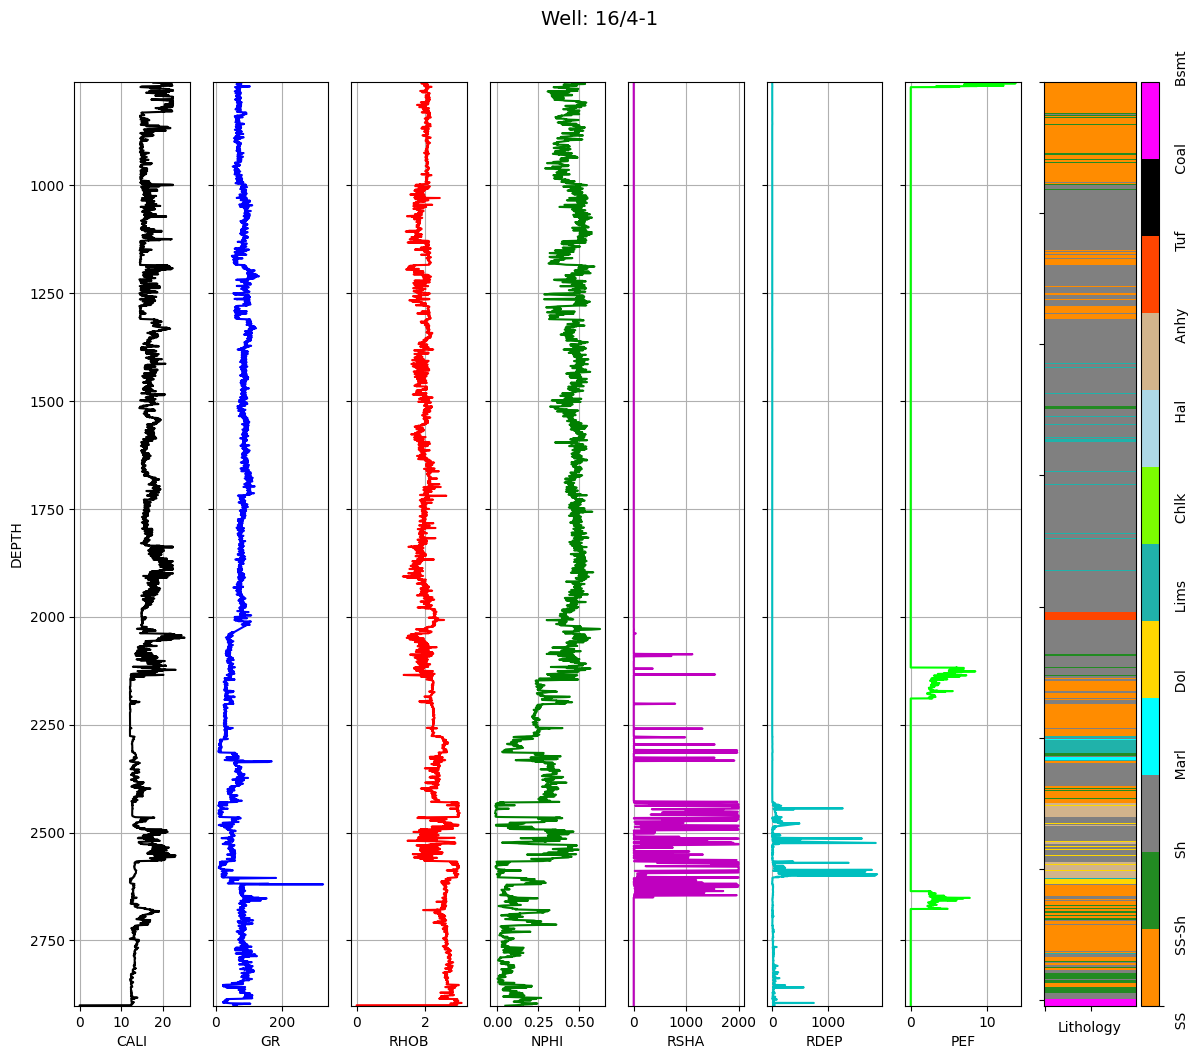

In [20]:
well_no=13
logs = pd.concat([X_imp,
                  Y], axis=1).rename(columns = {'FORCE_2020_LITHOFACIES_LITHOLOGY':'litho_real', 'DEPTH_MD':'Depth'
                                               })
make_facies_log_plot(logs[well==train_wells[well_no]], ['CALI', 'GR', 'RHOB', 'NPHI', 'RSHA', 'RDEP', 'PEF'],
                     train_wells[well_no],
                     facies_colors)

# Preprocessing and Model Training

## Preprocessing functions

In [21]:
def drop_columns(data, *args):

    '''
    function used to drop columns.
    args::
      data:  dataframe to be operated on
      *args: a list of columns to be dropped from the dataframe

    return: returns a dataframe with the columns dropped
    '''

    columns = []
    for _ in args:
        columns.append(_)

    data = data.drop(columns, axis=1)

    return data


In [22]:
def process(data):

    '''
    function to process dataframe by replacing missing, infinity values with -999

    args::
      data:  dataframe to be operated on

    returns dataframe with replaced values
    '''

    cols = list(data.columns)
    for _ in cols:

        data[_] = np.where(data[_] == np.inf, -999, data[_])
        data[_] = np.where(data[_] == np.nan, -999, data[_])
        data[_] = np.where(data[_] == -np.inf, -999, data[_])

    return data

## Feature Engineering

In [23]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):

    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug

In [24]:
# Feature gradient computation function
def augment_features_gradient(X, depth):

    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff

    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))

    return X_grad

In [25]:
# Combined feature augmentation function
def augment_features(X, well, depth, N_neig=1):

    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)

    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])

    return X_aug, padded_rows

## Functions for Analyzing the Results


In [27]:
from sklearn.metrics import accuracy_score, classification_report

def show_evaluation(predictions, true_labels):
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Accuracy is: {accuracy}')

    # Generate and print classification report
    class_report = classification_report(true_labels, predictions)
    print(f'Classification Report:\n{class_report}')

    return accuracy

In [28]:
def score(y_true, y_pred):

    '''
    custom metric used for evaluation
    args:
      y_true: actual prediction
      y_pred: predictions made
    '''

    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

# Model Architecture

In [31]:
class Model():

    '''
    class to lithology prediction
    '''

    def __init__(self, train, test):

        '''
        takes in the train and test dataframes
        '''

        self.train = train
        self.test = test


    def __call__(self, plot = True):

      return self.fit(plot)

    def preprocess(self, train, test):

        '''
        method to prepare datasets for training and predictions
        accepts both the train and test dataframes as arguments

        returns the prepared train, test datasets along with the
        lithology labels and numbers.

        '''

        #concatenating both train and test datasets for easier and uniform processing

        ntrain = train.shape[0]
        ntest = test.shape[0]
        target = train.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
        df = pd.concat((train, test)).reset_index(drop=True)

        #mapping the lithology labels to ordinal values for better modelling

        lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']

        lithology_numbers = {30000: 0,
                        65030: 1,
                        65000: 2,
                        80000: 3,
                        74000: 4,
                        70000: 5,
                        70032: 6,
                        88000: 7,
                        86000: 8,
                        99000: 9,
                        90000: 10,
                        93000: 11}

        lithology1 = lithology.map(lithology_numbers)

        #implementing Bestagini's augmentation procedure

        train_well = train.WELL.values
        train_depth = train.DEPTH_MD.values

        test_well = test.WELL.values
        test_depth = test.DEPTH_MD.values



        print(f'shape of concatenated dataframe before dropping columns {df.shape}')

        cols = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] #columns to be dropped
        df = drop_columns(df, *cols)
        print(f'shape of dataframe after dropping columns {df.shape}')
        print(f'{cols} were dropped')

        #Label encoding the GROUP, FORMATION and WELLS features as these improved the performance of the models on validations

        df['GROUP_encoded'] = df['GROUP'].astype('category')
        df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes
        df['FORMATION_encoded'] = df['FORMATION'].astype('category')
        df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes
        df['WELL_encoded'] = df['WELL'].astype('category')
        df['WELL_encoded'] = df['WELL_encoded'].cat.codes
        print(f'shape of dataframe after label encoding columns {df.shape}')


        #FURTHER PREPRATION TO SPLIT DATAFRAME INTO TRAIN AND TEST DATASETS AFTER PREPRATION
        print(f'Splitting concatenated dataframe into training and test datasets...')
        df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)
        print(df.shape)

        df = df.fillna(-999)
        df = process(df)
        data = df.copy()

        train2 = data[:ntrain].copy()
        train2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)

        test2 = data[ntrain:(ntest+ntrain)].copy()
        test2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
        test2 = test2.reset_index(drop=True)

        traindata = train2
        testdata = test2

        print(f'Shape of train and test datasets before augmentation {traindata.shape, testdata.shape}')

        traindata1, padded_rows = augment_features(pd.DataFrame(traindata).values, train_well, train_depth)
        testdata1, padded_rows = augment_features(pd.DataFrame(testdata).values, test_well, test_depth)

        print(f'Shape of train and test datasets after augmentation {traindata1.shape, testdata1.shape}')

        return traindata1, testdata1, lithology1, lithology_numbers

    # ___________________________________________________________________________________________________________________________________________________________
    def fit(self, plot):

      '''
      method to train model and make predictions

      returns the test predictions, trained model, and lithology numbers used for making the submission file
      '''

      traindata1, testdata1, lithology1, lithology_numbers = self.preprocess(self.train, self.test)

      #using a 10-fold stratified cross-validation technique and seting the shuffle parameter to true
      #as this improved the validation performance better

      split = 10
      kf = StratifiedKFold(n_splits=split, shuffle=True)

      open_test = np.zeros((len(testdata1), 12))

      #100 n-estimators and 10 max-depth
      model = XGBClassifier(n_estimators=100, max_depth=10, booster='gbtree',
                            objective='multi:softprob', learning_rate=0.1, random_state=0,
                            subsample=0.9, colsample_bytree=0.9,
                            eval_metric='mlogloss', verbose=2020, reg_lambda=1500)


      i = 1
      for (train_index, test_index) in kf.split(pd.DataFrame(traindata1), pd.DataFrame(lithology1)):
        X_train, X_test = pd.DataFrame(traindata1).iloc[train_index], pd.DataFrame(traindata1).iloc[test_index]
        Y_train, Y_test = pd.DataFrame(lithology1).iloc[train_index],pd.DataFrame(lithology1).iloc[test_index]

        model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_test, Y_test)], verbose=100)
        prediction = model.predict(X_test)
        print(show_evaluation(prediction, Y_test))

        print(f'-----------------------FOLD {i}---------------------')
        i+=1

        open_test += model.predict_proba(pd.DataFrame(testdata1))

      open_test= pd.DataFrame(open_test/split)

      open_test = np.array(pd.DataFrame(open_test).idxmax(axis=1))

      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')


      if plot: self.plot_feat_imp(model)
      return open_test, model, lithology_numbers


    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')



# Model Training

In [ ]:
#To train model and make prediction

func_= Model(train, test)
prediction, model, redundant = func_()

shape of concatenated dataframe before dropping columns (1307297, 29)
shape of dataframe after dropping columns (1307297, 24)
['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] were dropped
shape of dataframe after label encoding columns (1307297, 27)
Splitting concatenated dataframe into training and test datasets...
(1307297, 24)
Shape of train and test datasets before augmentation ((1170511, 23), (136786, 23))
Shape of train and test datasets after augmentation ((1170511, 92), (136786, 92))


/home/jupyter-mannat/.local/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/jupyter-mannat/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16243
[99]	validation_0-mlogloss:0.31760
Accuracy is: 0.8942606704712436
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87     16893
           1       0.81      0.68      0.74     15046
           2       0.92      0.97      0.94     72081
           3       0.85      0.76      0.81      3333
           4       0.67      0.05      0.09       169
           5       0.86      0.68      0.76      5632
           6       0.90      0.90      0.90      1051
           7       0.98      1.00      0.99       821
           8       0.90      0.80      0.84       109
           9       0.85      0.88      0.86      1524
          10       0.83      0.47      0.60       382
          11       0.00      0.00      0.00        11

    accuracy                           0.89    117052
   macro avg       0.79      0.67      0.70    117052
weighted avg       0.89      0.89      0.89    117052

0.8942606

/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter

[0]	validation_0-mlogloss:2.16199
[99]	validation_0-mlogloss:0.31647
Accuracy is: 0.8961563762804248
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     16893
           1       0.82      0.69      0.75     15046
           2       0.92      0.97      0.94     72081
           3       0.85      0.77      0.81      3333
           4       1.00      0.08      0.15       169
           5       0.85      0.69      0.76      5632
           6       0.92      0.89      0.91      1051
           7       0.99      0.99      0.99       821
           8       0.92      0.83      0.87       109
           9       0.86      0.86      0.86      1524
          10       0.87      0.45      0.59       382
          11       0.00      0.00      0.00        10

    accuracy                           0.90    117051
   macro avg       0.82      0.67      0.71    117051
weighted avg       0.89      0.90      0.89    117051

0.8961563

/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter

[0]	validation_0-mlogloss:2.16225
[99]	validation_0-mlogloss:0.31827
Accuracy is: 0.8948834268822992
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     16893
           1       0.82      0.69      0.75     15046
           2       0.92      0.97      0.94     72081
           3       0.84      0.75      0.79      3333
           4       0.88      0.04      0.08       168
           5       0.85      0.68      0.76      5632
           6       0.91      0.90      0.91      1052
           7       0.99      0.99      0.99       821
           8       0.86      0.89      0.87       109
           9       0.85      0.89      0.87      1524
          10       0.86      0.49      0.63       382
          11       0.00      0.00      0.00        10

    accuracy                           0.89    117051
   macro avg       0.80      0.68      0.70    117051
weighted avg       0.89      0.89      0.89    117051

0.8948834

/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter

[0]	validation_0-mlogloss:2.16151
[99]	validation_0-mlogloss:0.31705
Accuracy is: 0.8954643702317793
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     16894
           1       0.82      0.69      0.75     15046
           2       0.92      0.97      0.94     72080
           3       0.86      0.76      0.80      3333
           4       0.75      0.04      0.07       168
           5       0.85      0.69      0.76      5632
           6       0.91      0.90      0.90      1052
           7       0.99      1.00      0.99       821
           8       0.89      0.88      0.88       109
           9       0.85      0.86      0.86      1524
          10       0.82      0.47      0.60       382
          11       0.00      0.00      0.00        10

    accuracy                           0.90    117051
   macro avg       0.79      0.68      0.70    117051
weighted avg       0.89      0.90      0.89    117051

0.8954643

/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter

[0]	validation_0-mlogloss:2.16205
[99]	validation_0-mlogloss:0.31764
Accuracy is: 0.8947894507522363
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     16894
           1       0.82      0.69      0.75     15046
           2       0.92      0.97      0.94     72080
           3       0.85      0.76      0.80      3333
           4       0.67      0.02      0.05       169
           5       0.85      0.70      0.77      5632
           6       0.89      0.91      0.90      1052
           7       0.98      0.99      0.99       821
           8       0.89      0.81      0.84       108
           9       0.85      0.86      0.85      1524
          10       0.80      0.46      0.59       382
          11       0.00      0.00      0.00        10

    accuracy                           0.89    117051
   macro avg       0.78      0.67      0.70    117051
weighted avg       0.89      0.89      0.89    117051

0.8947894

/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter

[0]	validation_0-mlogloss:2.16205
[99]	validation_0-mlogloss:0.31569
Accuracy is: 0.8957377553374171
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     16894
           1       0.82      0.69      0.75     15045
           2       0.92      0.97      0.94     72080
           3       0.84      0.75      0.79      3333
           4       0.73      0.07      0.12       169
           5       0.85      0.70      0.77      5632
           6       0.91      0.89      0.90      1051
           7       0.99      0.99      0.99       822
           8       0.91      0.81      0.86       108
           9       0.85      0.86      0.86      1525
          10       0.87      0.53      0.66       382
          11       0.00      0.00      0.00        10

    accuracy                           0.90    117051
   macro avg       0.80      0.68      0.71    117051
weighted avg       0.89      0.90      0.89    117051

0.8957377

/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter

[0]	validation_0-mlogloss:2.16208
[99]	validation_0-mlogloss:0.31818
Accuracy is: 0.8940889014190395
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     16894
           1       0.82      0.69      0.75     15045
           2       0.92      0.97      0.94     72080
           3       0.84      0.74      0.79      3333
           4       0.80      0.05      0.09       169
           5       0.84      0.69      0.76      5632
           6       0.92      0.89      0.91      1051
           7       0.98      0.99      0.99       822
           8       0.88      0.83      0.86       108
           9       0.84      0.86      0.85      1525
          10       0.89      0.51      0.65       382
          11       0.00      0.00      0.00        10

    accuracy                           0.89    117051
   macro avg       0.80      0.67      0.70    117051
weighted avg       0.89      0.89      0.89    117051

0.8940889

/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter

[0]	validation_0-mlogloss:2.16226
[99]	validation_0-mlogloss:0.32144
Accuracy is: 0.893055163988347
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     16894
           1       0.81      0.68      0.74     15045
           2       0.92      0.97      0.94     72080
           3       0.84      0.75      0.79      3333
           4       0.73      0.05      0.09       169
           5       0.85      0.68      0.76      5632
           6       0.90      0.91      0.90      1051
           7       0.99      0.99      0.99       822
           8       0.90      0.86      0.88       108
           9       0.86      0.87      0.86      1525
          10       0.79      0.44      0.57       382
          11       0.00      0.00      0.00        10

    accuracy                           0.89    117051
   macro avg       0.79      0.67      0.70    117051
weighted avg       0.89      0.89      0.89    117051

0.89305516

/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter

[0]	validation_0-mlogloss:2.16193
[99]	validation_0-mlogloss:0.31826
Accuracy is: 0.8943281133864726
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     16894
           1       0.81      0.69      0.75     15045
           2       0.92      0.97      0.94     72080
           3       0.85      0.75      0.80      3333
           4       0.89      0.05      0.09       169
           5       0.85      0.69      0.76      5632
           6       0.90      0.89      0.90      1051
           7       0.98      0.99      0.99       821
           8       0.88      0.86      0.87       108
           9       0.84      0.87      0.86      1525
          10       0.84      0.46      0.59       382
          11       0.00      0.00      0.00        11

    accuracy                           0.89    117051
   macro avg       0.80      0.67      0.70    117051
weighted avg       0.89      0.89      0.89    117051

0.8943281

/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-mannat/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter

[0]	validation_0-mlogloss:2.16197


In [ ]:
prediction

array([2, 2, 2, ..., 0, 1, 0])